In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
from model import VAE

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
mnist = input_data.read_data_sets('data/', reshape=False)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


## Training review
We save the result of the model at the end of each epoch. Between epochs 0 and 3, you can see the output image becoming more defined.

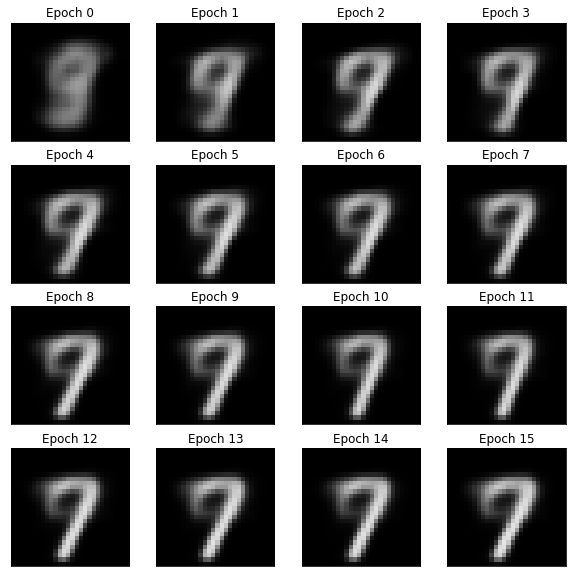

In [3]:
plt.figure(figsize=(10, 10))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.xticks([]), plt.yticks([])
    plt.title(f'Epoch {i}')
    plt.imshow(cv2.imread(f'samples/{i}.png'))
plt.show()

## Model evaluation
Evaluate the model on several test images. There are occasionally instances where the class of the output is different from that of the input image (i.e. *3* produces *8*).

In addition, the blurriness of the images are a natural drawback of image generation with VAEs.

In [4]:
model_path = 'model/vae_xent/model'

tf.reset_default_graph()
model = VAE()
saver = tf.train.Saver()
sess = tf.Session()
saver.restore(sess, model_path)

INFO:tensorflow:Restoring parameters from model/vae_xent/model


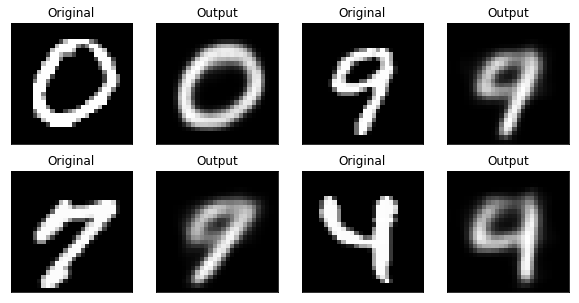

In [5]:
x, y = mnist.test.next_batch(4)
out = sess.run(model.out, feed_dict={
    model.x: x,
})

plt.figure(figsize=(10, 5))
for i in range(4):
    plt.subplot(2, 4, i*2 + 1)
    plt.title('Original')
    plt.xticks([]), plt.yticks([])
    plt.imshow(x[i].reshape([28, 28]), cmap='gray')
    
    plt.subplot(2, 4, i*2 + 2)
    plt.title('Output')
    plt.xticks([]), plt.yticks([])
    plt.imshow(np.squeeze(out[i], axis=-1), cmap='gray')

## Exploring latent space distribution
The output of the encoder network has shape `[-1, 2]`. This means that 2 values are obtained per image. The two values are then taken to be `(x, y)` coordinates.

The output for each test image in the MNIST dataset is then taken and plotted accordingly.
While the distribution of these points are trained to converge to a normal distribution, the non-zero values in this distribution are explained by the **ReLU activation** in the fully-connected layers of the encoder network.

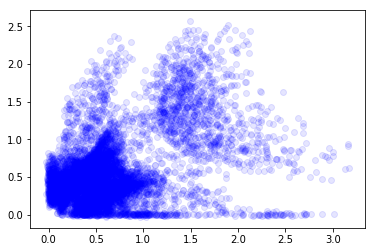

In [6]:
z = sess.run(model.z, feed_dict={
    model.x: mnist.test.images
})
plt.scatter(z[:, 0], z[:, 1], color=(0, 0, 1, 0.1));

## Visualizing latent space on output images
Here we visualize the output images over a range of values for the latent space. We use the interval of `[0, 2]` due to the plot above.

In [7]:
x = np.arange(0, 2, 0.1)
y = np.arange(0, 2, 0.1)
xx, yy = np.meshgrid(x, y)
pts = np.stack([xx.flatten(), yy.flatten()], axis=-1)
pts[:10]

array([[0. , 0. ],
       [0.1, 0. ],
       [0.2, 0. ],
       [0.3, 0. ],
       [0.4, 0. ],
       [0.5, 0. ],
       [0.6, 0. ],
       [0.7, 0. ],
       [0.8, 0. ],
       [0.9, 0. ]])

In [8]:
tf.reset_default_graph()

ph = tf.placeholder(tf.float32, [None, 2])
out = VAE.decoder_network(ph)
saver = tf.train.Saver()

with tf.Session() as sess:
    saver.restore(sess, model_path)
    output_images = sess.run(tf.nn.sigmoid(out), feed_dict={ph: pts})
output_images.shape

INFO:tensorflow:Restoring parameters from model/vae_xent/model


(400, 28, 28, 1)

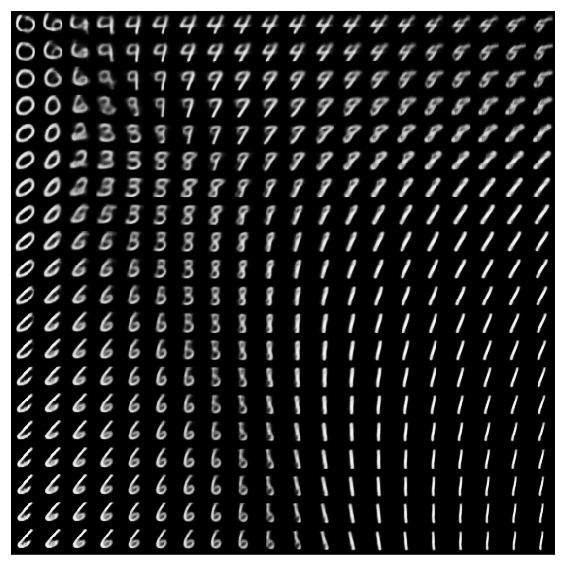

In [9]:
output_images = output_images.reshape([len(y), len(x), 28, 28])
image = np.zeros([28 * len(y), 28 * len(x)], np.float32)
for r in range(len(y)):
    for c in range(len(x)):
        image[r*28:(r+1)*28, c*28:(c+1)*28] = output_images[r, c]
        
plt.figure(figsize=(10, 10))
plt.xticks([]), plt.yticks([])
plt.imshow(image, cmap='gray');

## Generating new images

In [10]:
n_x, n_y = 10, 10
latent_vectors = np.abs(np.random.normal(0, 1, size=[n_x * n_y, 2]))
latent_vectors[:5]

array([[0.08988466, 0.31877862],
       [0.54900567, 1.79718783],
       [0.10979059, 0.31543474],
       [0.64372077, 0.82740034],
       [1.2064513 , 0.42172252]])

In [11]:
tf.reset_default_graph()

ph = tf.placeholder(tf.float32, [None, 2])
out = VAE.decoder_network(ph)
saver = tf.train.Saver()

with tf.Session() as sess:
    saver.restore(sess, model_path)
    output_images = sess.run(tf.nn.sigmoid(out), feed_dict={ph: latent_vectors})
output_images.shape

INFO:tensorflow:Restoring parameters from model/vae_xent/model


(100, 28, 28, 1)

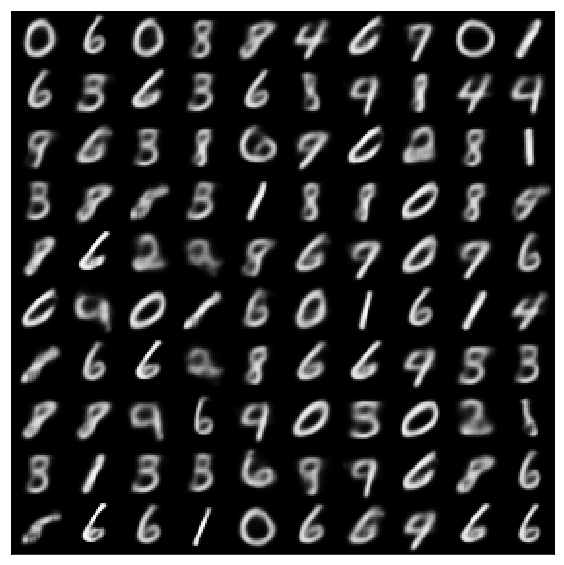

In [12]:
output_images = output_images.reshape([n_y, n_x, 28, 28])
image = np.zeros([n_y * 28, n_x * 28], np.float32)
for r in range(n_y):
    for c in range(n_x):
        image[r*28:(r+1)*28, c*28:(c+1)*28] = output_images[r, c]
        
plt.figure(figsize=(10, 10))
plt.xticks([]), plt.yticks([])
plt.imshow(image, cmap='gray');